In [1]:
from sklearn.ensemble import RandomForestClassifier

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fast_borf import BorfBuilder
from fast_borf.pipeline.zero_columns_remover import ZeroColumnsRemover
from fast_borf.pipeline.reshaper import ReshapeTo2D
from fast_borf.pipeline.to_scipy import ToScipySparse
from downtime import load_dataset
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeClassifierCV
from sklearn.preprocessing import FunctionTransformer

import os
from copy import deepcopy

In [3]:

os.chdir('..')

In [ ]:
from mascots.explainer.borf import BorfExplainer
from bin.utils.models import LSTM
import torch
import os
from torch import Tensor
from bin.utils.models import LSTM, get_trainer
from torch.utils.data import DataLoader, TensorDataset
from bin.utils.data import get_data

In [5]:
X_train, y_train, X_test, y_test = load_dataset("CBF")()

In [6]:
lstm = LSTM(input_size=128, hidden_size=1024, num_layers=5, output_size=3, lr=1e-3)

batch_size = 126

train_dataloader = DataLoader(TensorDataset(Tensor(X_train), Tensor(y_train)), batch_size=batch_size)
test_dataloader = DataLoader(TensorDataset(Tensor(X_test), Tensor(y_test)), batch_size=126)

In [7]:
trainer = get_trainer(max_epochs=20)
trainer.fit(model=lstm, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | lstm    | LSTM    | 38.3 M | train
1 | fc      | Linear  | 3.1 K  | train
2 | softmax | Softmax | 0      | train
--------------------------------------------
38.3 M    Trainable params
0         Non-trainable params
38.3 M    Total params
153.268   Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/dawid/miniconda3/envs/borf/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/dawid/miniconda3/envs/borf/lib/python3.11/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/home/dawid/miniconda3/envs/borf/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/dawid/miniconda3/envs/borf/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.p

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [8]:
y_preds = []
ys = []
with torch.no_grad():
    for X, y in test_dataloader:
        y_pred = lstm.forward(X)
        y_preds.append(y_pred)
        ys.append(y)
y_preds = torch.concat(y_preds)
ys = torch.concat(ys)
y_preds = torch.argmax(y_preds, dim=1)

torch.mean((ys == y_preds).float())

tensor(0.7056)

In [37]:
with torch.no_grad():
    explainer = BorfExplainer(lstm.forward_cls)
    scores = explainer.build(np.array(X_train), RandomForestClassifier(n_estimators=100, max_features=0.01), 'shap', attribution_args={'mode': 'normal'})

In [38]:
scores

{'all_data_scores': {'accuracy': 1.0,
  'balanced_accuracy': np.float64(1.0),
  'f1 (micro)': np.float64(1.0),
  'recall (micro)': np.float64(1.0),
  'precision (micro)': np.float64(1.0)}}

In [39]:
IDX: int = 0

In [40]:
counterfactual, meta = explainer.counterfactual(
    np.array(X_train[IDX:(IDX+1)]),
    target_cls=2,
    max_borf_changes=5,
    n_restarts=1, 
    select_top_k=2,
    min_symbol_size=4,
    max_symbol_size=4,
    # min_word_len_change=16,
    # max_word_len_change=64,
    C=1
)

/home/dawid/miniconda3/envs/borf/lib/python3.11/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


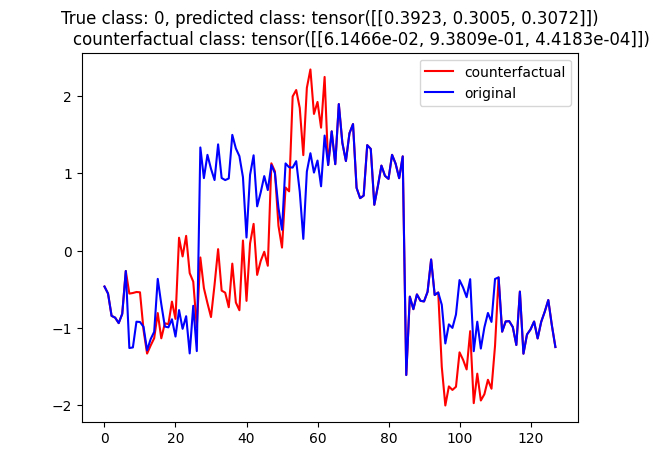

In [41]:
with torch.no_grad():

    coutnerfactual_idx = 0

    steps = np.arange(np.array(X_train).shape[2])

    # for i in range(len(counterfactual)):
    plt.plot(steps, counterfactual[coutnerfactual_idx][0,:], c='r', label='counterfactual')
    plt.plot(steps, X_train[IDX,0,:], c='b', label="original")

    probs_org = lstm(Tensor(X_train[[IDX],:,:]))

    probs_cnt = lstm(Tensor(counterfactual[[coutnerfactual_idx],:,:]))

    plt.title(f"""True class: {y_train[IDX]}, predicted class: {probs_org}
            counterfactual class: {probs_cnt}""")

    plt.legend()

In [42]:
cnt_steps = list(map(lambda x: x['new_obs'], meta[0].values()))
cnt_shapes = list(map(lambda x: x['added_shapes_candidates'][x['selected_swap'][0]].tolist(), meta[0].values()))

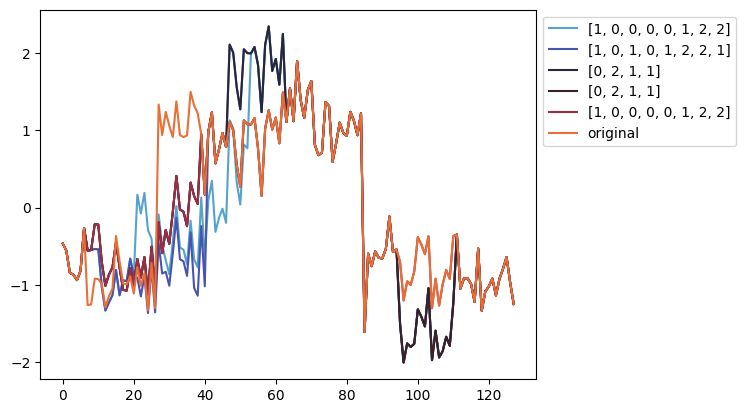

In [43]:
pallete = sns.color_palette("icefire", n_colors=len(cnt_steps)+1)

for idx, (cnt_step, shape) in enumerate((zip(cnt_steps[::-1], cnt_shapes[::-1]))):
    plt.plot(steps, cnt_step[0,0,:], c=pallete[idx], label=f'{shape}')
    
plt.plot(steps, X_train[IDX,0,:], c=pallete[-1], label='original')
plt.legend(bbox_to_anchor=(1,1))


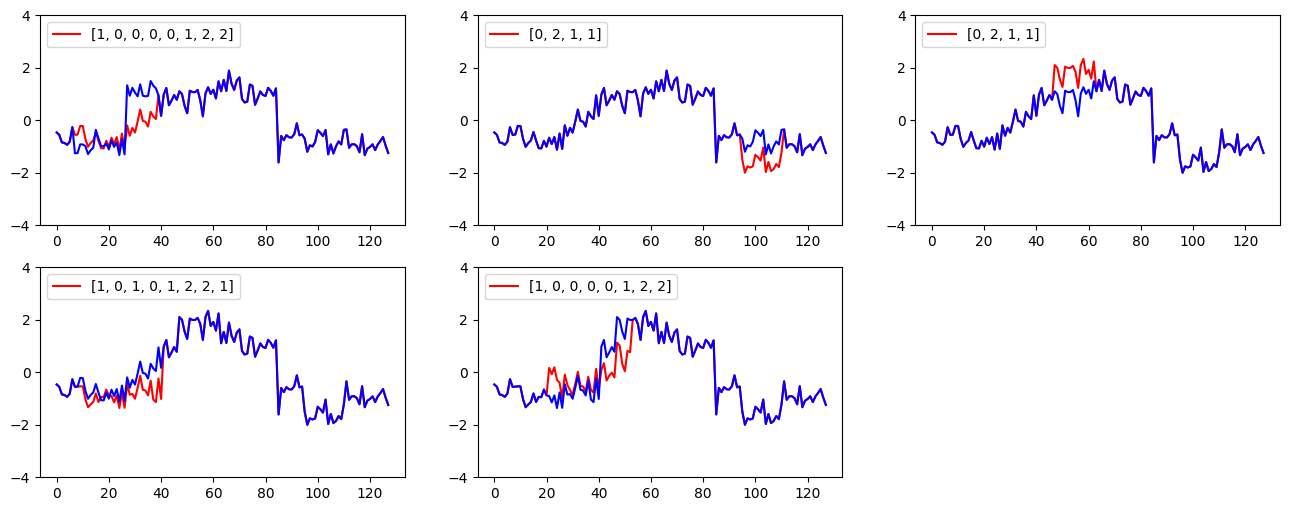

In [44]:
ncols = 3
nrows = (len(cnt_steps)+1) // ncols

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16, 3*nrows))
ax = ax.flatten()

for idx in range(len(cnt_steps)):
    ax[idx].plot(steps, cnt_steps[idx][0,0,:], c='r', label=f'{cnt_shapes[idx]}')
    if idx == 0:
        ax[idx].plot(steps, X_train[IDX,0,:], c='b')
    else:
        ax[idx].plot(steps, cnt_steps[idx-1][0,0,:], c='b')
        
    ax[idx].legend(loc='upper left')
    ax[idx].set_ylim((-4, 4))
    
for idx in range(len(cnt_steps), nrows*ncols):
    fig.delaxes(ax[idx])